In [51]:
import numpy as np
import pickle
import json
from collections import defaultdict
import re
from pprint import pprint
from dateutil.parser import parse

In [2]:
with open("reviewratings_iclr17_peeread.pkl", "rb") as f:
    rr = pickle.load(f)

In [3]:
type(rr)

dict

In [4]:
rr.keys()

dict_keys(['438', '705', '383', '627', '405', '590', '380', '421', '374', '442', '308', '379', '612', '436', '697', '525', '552', '529', '396', '707', '770', '751', '435', '389', '651', '348', '358', '344', '785', '376', '523', '448', '537', '629', '449', '322', '553', '719', '573', '526', '636', '640', '441', '781', '499', '534', '592', '532', '763', '644', '551', '413', '507', '700', '641', '369', '581', '496', '319', '362', '654', '608', '384', '680', '474', '572', '691', '504', '373', '606', '730', '632', '657', '433', '634', '663', '345', '306', '452', '582', '515', '637', '706', '517', '304', '734', '530', '544', '338', '783', '681', '741', '668', '563', '328', '446', '579', '316', '406', '594', '555', '667', '658', '411', '464', '653', '493', '494', '709', '720', '749', '774', '485', '574', '483', '567', '462', '633', '400', '735', '451', '789', '578', '609', '513', '540', '444', '665', '447', '487', '360', '390', '508', '356', '728', '733', '365', '689', '725', '343', '688', '6

In [5]:
rr['312'].keys(), rr['612']['accepted']

(dict_keys(['title', 'authors', 'abstract', 'conference', 'accepted', 'id', 'reviews', 'histories']),
 False)

In [6]:
rr['312']['reviews'][1]

{'DATE': '19 May 2017 (modified: 02 Jun 2017)',
 'IS_ANNOTATED': True,
 'IS_META_REVIEW': False,
 'ORIGINALITY': 4,
 'OTHER_KEYS': 'ICLR 2017 conference AnonReviewer2',
 'RECOMMENDATION_UNOFFICIAL': 5,
 'SOUNDNESS_CORRECTNESS': 5,
 'TITLE': 'Hyperparameters for SotA PTB word level LM',
 'comments': 'The paper reports that "[a]fter the controller RNN is done training, we take the best RNN cell according to the lowest validation perplexity and then run a grid search over learning rate, weight initialization, dropout rates and decay epoch. The best cell found was then run with three different configurations and sizes to increase its capacity."\n\nIs it possible for you to include (or provide here) the hyperparameters and type of dropout (i.e. recurrent dropout, embedding dropout, ...) used? Without them, replication would at best require a great deal of trial and error. As with "Recurrent Neural Network Regularization" (Zaremba et al., 2014), releasing a base set of hyper parameters great

In [7]:
uniq = []

for k in rr:
    if "reviews" in rr[k]:
        for rev in rr[k]["reviews"]:
            if "OTHER_KEYS" in rev:
                uniq = uniq + list(rev.keys())
                uniq = list(set(uniq))
print(uniq)

['SOUNDNESS_CORRECTNESS', 'CLARITY', 'RECOMMENDATION', 'ORIGINALITY', 'IS_META_REVIEW', 'TITLE', 'IMPACT', 'RECOMMENDATION_UNOFFICIAL', 'REVIEWER_CONFIDENCE', 'DATE', 'comments', 'OTHER_KEYS', 'IS_ANNOTATED', 'SUBSTANCE', 'MEANINGFUL_COMPARISON', 'APPROPRIATENESS']


In [29]:
# acl_aspects = ["MEANINGFUL_COMPARISON", "IMPACT", "ORIGINALITY", "RECOMMENDATION", "SUBSTANCE", "SOUNDNESS_CORRECTNESS", "APPROPRIATENESS", "CLARITY"]

# aspect_dict = defaultdict(dict)
# inspect_list = []

# for k in rr:
#     new_key = rr[k]["title"].strip().lower()
    
#     new_key = re.sub('[^0-9a-zA-Z]+', '', new_key)
    
#     aspect_dict[new_key]["title"] = rr[k]["title"]
#     aspect_dict[new_key]["dec"] = rr[k]["accepted"]
#     aspect_dict[new_key]["pr_id"] = k
#     if "reviews" in rr[k]:
#         for rev in rr[k]["reviews"]:
#             if "OTHER_KEYS" in rev:
#                 if rev["OTHER_KEYS"].find("AnonReviewer") > -1:
#                     for asp in acl_aspects:
#                         if asp in rev:
#                             if asp in aspect_dict[new_key]:
#                                 aspect_dict[new_key][asp].append(rev[asp])
#                             else:
#                                 aspect_dict[new_key][asp] = [rev[asp]]
#             else:
#                 for asp in acl_aspects:
#                     if asp in rev:
#                         inspect_list.append((k, rev))

### Fixing multiple redundant comments

In [99]:
acl_aspects = ["MEANINGFUL_COMPARISON", "IMPACT", "ORIGINALITY", "RECOMMENDATION", "SUBSTANCE", "SOUNDNESS_CORRECTNESS", "APPROPRIATENESS", "CLARITY"]

aspect_dict = defaultdict(dict)
inspect_list = {}

for k in rr:
    new_key = rr[k]["title"].strip().lower()
    
    new_key = re.sub('[^0-9a-zA-Z]+', '', new_key)
    
    aspect_dict[new_key]["title"] = rr[k]["title"]
    aspect_dict[new_key]["dec"] = rr[k]["accepted"]
    aspect_dict[new_key]["pr_id"] = k
    
    inspect_list[new_key] = {}
    
    if "reviews" in rr[k]:
        for rev in rr[k]["reviews"]:
            if "OTHER_KEYS" in rev:
                if rev["OTHER_KEYS"].find("AnonReviewer") > -1:
                    anon_reviewer = rev["OTHER_KEYS"].split(" ")[-1]
                    if anon_reviewer in inspect_list[new_key]:
                        inspect_list[new_key][anon_reviewer]
                    else:
                        inspect_list[new_key][anon_reviewer] = {}
                        if "DATE" in rev:
                            if rev["DATE"].find("modified") > -1:
                                try:
                                    rev["DATE"] = re.findall('([0-9]+ [A-Za-z]+ [0-9][0-9][0-9][0-9]\))$', d)[0][:-1]
                                except Exception:
                                    print(rev["DATE"])
                            else:
                                try:
                                    rev["DATE"] = rev["DATE"].replace("(", "")
                                    rev["DATE"] = rev["DATE"].replace(")", "")
                                    date_of_review = parse(rev["DATE"])
                                except Exception:
                                    print(rev["DATE"], k)
                        else:
                            date_of_review = parse("1 Jan 2000")
                    
                        for asp in acl_aspects:
                            if asp in rev:
                                if asp in inspect_list[new_key][anon_reviewer]:
                                    prev_date = inspect_list[new_key][anon_reviewer][asp][1]
                                    if prev_date < date_of_review:
                                        inspect_list[new_key][anon_reviewer][asp] = [rev[asp], date_of_review]
                                else:
                                    inspect_list[new_key][anon_reviewer][asp] = [rev[asp], date_of_review]
            else:
                for asp in acl_aspects:
                    if asp in rev:
                        inspect_list.append((k, rev))

In [91]:
d = "16 Dec 2016 (modified: 20 Jan 2017)"
last_digits = re.findall('([0-9]+ [A-Za-z]+ [0-9][0-9][0-9][0-9]\))$', d)

In [100]:
inspect_list

{'abaselinefordetectingmisclassifiedandoutofdistributionexamplesinneuralnetworks': {'AnonReviewer1': {'MEANINGFUL_COMPARISON': [4,
    datetime.datetime(2016, 12, 19, 0, 0)],
   'ORIGINALITY': [4, datetime.datetime(2016, 12, 19, 0, 0)],
   'RECOMMENDATION': [6, datetime.datetime(2016, 12, 19, 0, 0)]},
  'AnonReviewer2': {'RECOMMENDATION': [6,
    datetime.datetime(2016, 12, 16, 0, 0)]},
  'AnonReviewer3': {'IMPACT': [2, datetime.datetime(2017, 1, 20, 0, 0)],
   'ORIGINALITY': [3, datetime.datetime(2017, 1, 20, 0, 0)],
   'RECOMMENDATION': [6, datetime.datetime(2017, 1, 20, 0, 0)],
   'SOUNDNESS_CORRECTNESS': [3, datetime.datetime(2017, 1, 20, 0, 0)]}},
 'acompareaggregatemodelformatchingtextsequences': {'AnonReviewer1': {'RECOMMENDATION': [7,
    datetime.datetime(2016, 12, 16, 0, 0)],
   'SOUNDNESS_CORRECTNESS': [5, datetime.datetime(2016, 12, 16, 0, 0)],
   'SUBSTANCE': [4, datetime.datetime(2016, 12, 16, 0, 0)]},
  'AnonReviewer2': {'ORIGINALITY': [3, datetime.datetime(2016, 12, 11,

### Collate 

In [102]:
for k in inspect_list:
    for anon_rev in inspect_list[k]:
        for asp in inspect_list[k][anon_rev]:
            if asp in aspect_dict[k]:
                aspect_dict[k][asp].append(inspect_list[k][anon_rev][asp][0])
            else:
                aspect_dict[k][asp] = [inspect_list[k][anon_rev][asp][0]]

In [31]:
len(aspect_dict)

427

In [104]:
len(aspect_dict)

427

In [105]:
acl_aspects = ["MEANINGFUL_COMPARISON", "IMPACT", "ORIGINALITY", "RECOMMENDATION", "SUBSTANCE", "SOUNDNESS_CORRECTNESS", "APPROPRIATENESS", "CLARITY"]
count_dict = defaultdict(int)

for k in aspect_dict:
    for asp in acl_aspects:
        if asp in aspect_dict[k]:
            count_dict[asp] +=1
print(count_dict)

defaultdict(<class 'int'>, {'SOUNDNESS_CORRECTNESS': 74, 'CLARITY': 79, 'RECOMMENDATION': 427, 'ORIGINALITY': 88, 'SUBSTANCE': 47, 'MEANINGFUL_COMPARISON': 35, 'APPROPRIATENESS': 13, 'IMPACT': 64})


In [106]:
data_dir = "../ICLR data/masterdata_unbalanced/"
year = 2017
paper_file = "papers_{}.pkl".format(year)


with open(data_dir+paper_file, "rb") as f:
    papers_data = pickle.load(f)

In [107]:
len(papers_data)

490

In [108]:
papers_data["B1-Hhnslg"]["content"]["title"]

'Prototypical Networks for Few-shot Learning'

In [221]:
final_dict = {}

not_found = []

for k in papers_data:
    t = papers_data[k]["content"]["title"].strip().lower()
    t = re.sub('[^0-9a-zA-Z]+', '', t)
    if t in aspect_dict:
        final_dict[k] = aspect_dict[t]
    else:
        print(t, k)
        not_found.append(t)

adversarialexamplesinthephysicalworld S1OufnIlx
boostingimagecaptioningwithattributes BkdpaH9ll
qpropsampleefficientpolicygradientwithanoffpolicycritic SJ3rcZcxl
deepbiaffineattentionforneuraldependencyparsing Hk95PK9le
sentenceorderingusingrecurrentneuralnetworks S1AG8zYeg
progressiveattentionnetworksforvisualattributeprediction HyEeMu_xx
alearnedrepresentationforartisticstyle BJO-BuT1g
multiviewgenerativeadversarialnetworks SJgWQPcxl
generativemodelsandmodelcriticismviaoptimizedmaximummeandiscrepancy HJWHIKqgl
theconcretedistributionacontinuousrelaxationofdiscreterandomvariables S1jE5L5gl
enforcingconstraintsonoutputswithunconstrainedinference S1Jhfftgx
generatinglonganddiverseresponseswithneuralconversationmodels HJDdiT9gl
semisuperviseddeeplearningbymetricembedding r1R5Z19le
bidirectionalattentionflowformachinecomprehension HJ0UKP9ge
neuralprogramlattices HJjiFK5gx
geometryofpolysemy HJpfMIFll
moderegularizedgenerativeadversarialnetworks HJKkY35le
representinginferentialuncertainty

In [110]:
len(not_found)

63

In [111]:
final_dict

{'B1-Hhnslg': {'RECOMMENDATION': [5, 4, 6],
  'dec': False,
  'pr_id': '559',
  'title': 'Prototypical Networks for Few-shot Learning'},
 'B1-q5Pqxl': {'CLARITY': [5, 5],
  'IMPACT': [3],
  'ORIGINALITY': [5],
  'RECOMMENDATION': [7, 6, 6],
  'SUBSTANCE': [5],
  'dec': True,
  'pr_id': '384',
  'title': 'Machine Comprehension Using Match-LSTM and Answer Pointer'},
 'B16Jem9xe': {'RECOMMENDATION': [8, 7],
  'dec': False,
  'pr_id': '534',
  'title': 'Learning in Implicit Generative Models'},
 'B16dGcqlx': {'CLARITY': [5],
  'ORIGINALITY': [1],
  'RECOMMENDATION': [6, 5],
  'SOUNDNESS_CORRECTNESS': [4],
  'dec': True,
  'pr_id': '341',
  'title': 'Third Person Imitation Learning'},
 'B184E5qee': {'CLARITY': [5],
  'IMPACT': [2],
  'ORIGINALITY': [2],
  'RECOMMENDATION': [5, 7, 9],
  'SOUNDNESS_CORRECTNESS': [4],
  'dec': True,
  'pr_id': '339',
  'title': 'Improving Neural Language Models with a Continuous Cache'},
 'B186cP9gx': {'RECOMMENDATION': [3, 4, 4],
  'dec': False,
  'pr_id': '6

In [222]:
papers_data["S1OufnIlx"]

{'cdate': None,
 'content': {'TL;DR': '',
  'abstract': 'Most existing machine learning classifiers are highly vulnerable to adversarial examples.\nAn adversarial example is a sample of input data which has been modified\nvery slightly in a way that is intended to cause a machine learning classifier\nto misclassify it.\nIn many cases, these modifications can be so subtle that a human observer does\nnot even notice the modification at all, yet the classifier still makes a mistake.\nAdversarial examples pose security concerns\nbecause they could be used to perform an attack on machine learning systems, even if the adversary has no\naccess to the underlying model.\nUp to now, all previous work has assumed a threat model in which the adversary can\nfeed data directly into the machine learning classifier.\nThis is not always the case for systems operating in the physical world,\nfor example those which are using signals from cameras and other sensors as input.\nThis paper shows that even in

In [112]:
with open("./features/rev_aspects_2017_peerread.pkl", "wb") as f:
    pickle.dump(final_dict, f)

In [113]:
ls features/

all_data_features_17_20.pkl          data_features_csv-2017.pkl
all_data_features_csv_17_20_new.pkl  features_csv_17_20.pkl
all_data_features_csv_2017_new.pkl   rev_aspects_2017_peerread.pkl
data_csv-2017-20.pkl


## Data Sanity Verification

In [114]:
with open("./features/rev_aspects_2017_peerread.pkl", "rb") as f:
    review_scores = pickle.load(f)

In [115]:
review_scores["B1-q5Pqxl"]

{'CLARITY': [5, 5],
 'IMPACT': [3],
 'ORIGINALITY': [5],
 'RECOMMENDATION': [7, 6, 6],
 'SUBSTANCE': [5],
 'dec': True,
 'pr_id': '384',
 'title': 'Machine Comprehension Using Match-LSTM and Answer Pointer'}

In [116]:
len(rr["384"]["reviews"])

18

In [40]:
pprint(rr["384"]["reviews"])

[{'IS_META_REVIEW': True,
  'comments': 'SUMMARY.\n'
              'This paper proposes a new neural network architectures for '
              'solving the task of reading comprehension question answering '
              'where the goal is answering a questions regarding a given text '
              'passage.\n'
              'The proposed model combines two well-know neural network '
              'architectures match-lstm and pointer nets.\n'
              'First the passage and the questions are encoded with a '
              'unidirectional LSTM.\n'
              'Then the encoded words in the passage and the encoded words in '
              'the questions are combined with an attention mechanism so that '
              'each word of the passage has a certain degree of compatibility '
              'with the question.\n'
              'For each word in the passage the word representation and the '
              'weighted representation of the query is concatenated and passed '
    

In [ ]:
'CLARITY': 5,
  'DATE': '17 Dec 2016',
  'IS_ANNOTATED': True,
  'IS_META_REVIEW': False,
  'OTHER_KEYS': 'ICLR 2017 conference AnonReviewer3',
  'RECOMMENDATION': 6,
  'REVIEWER_CONFIDENCE': 4,
  'SUBSTANCE': 5,
    
    
{'CLARITY': 5,
  'DATE': '03 Dec 2016',
  'IS_ANNOTATED': True,
  'IS_META_REVIEW': False,
  'OTHER_KEYS': 'ICLR 2017 conference AnonReviewer3',
  'SUBSTANCE': 5,
  'TITLE': 'Clarify contribution',
  'comments': ''},


{'CLARITY': 5,
  'DATE': '17 Dec 2016',
  'IS_ANNOTATED': True,
  'IS_META_REVIEW': False,
  'OTHER_KEYS': 'ICLR 2017 conference AnonReviewer3',
  'RECOMMENDATION': 6,
  'REVIEWER_CONFIDENCE': 4,
  'SUBSTANCE': 5,
  'TITLE': 'Review: Interesting combination of existing approaches with '
           'encouraging results',
  'comments': 'The paper looks at the problem of locating the answer to a '
              'question in a text (For this task the answer is always part of '
              'the input text). For this the paper proposes to combine two '}

{'CLARITY': 5,
  'DATE': '03 Dec 2016',
  'IS_ANNOTATED': True,
  'IS_META_REVIEW': False,
  'OTHER_KEYS': 'ICLR 2017 conference AnonReviewer3',
  'SUBSTANCE': 5,
  'TITLE': 'Clarify contribution',
  'comments': ''},
  

In [26]:
dt = parse('03 dec 2016')
dt1 = parse('03 Dec 2016')

In [12]:
print(dt)
print(dt.strftime('%d/%m/%Y'))

2016-12-03 00:00:00
03/12/2016


In [27]:
dt > dt1, dt < dt1, dt == dt1

(False, False, True)

In [28]:
dt, dt1

(datetime.datetime(2016, 12, 3, 0, 0), datetime.datetime(2016, 12, 3, 0, 0))

# Review Score Data Stats

In [126]:
import matplotlib.pyplot as plt

In [117]:
acl_aspects = ["SOUNDNESS_CORRECTNESS", "CLARITY", "ORIGINALITY", "SUBSTANCE", "MEANINGFUL_COMPARISON", "APPROPRIATENESS", "IMPACT", "RECOMMENDATION"]
count_dict = defaultdict(int)

for k in aspect_dict:
    for asp in acl_aspects:
        if asp in aspect_dict[k]:
            count_dict[asp] +=1
print(count_dict)

defaultdict(<class 'int'>, {'SOUNDNESS_CORRECTNESS': 74, 'CLARITY': 79, 'RECOMMENDATION': 427, 'ORIGINALITY': 88, 'SUBSTANCE': 47, 'MEANINGFUL_COMPARISON': 35, 'APPROPRIATENESS': 13, 'IMPACT': 64})


In [120]:
sorted_asps = sorted(count_dict.items(), key=lambda x: x[1], reverse=True)

In [130]:
x_axis = []
y_axis = []
for val in sorted_asps:
    x_axis.append(val[0])
    y_axis.append(round(val[1]/427, 3))

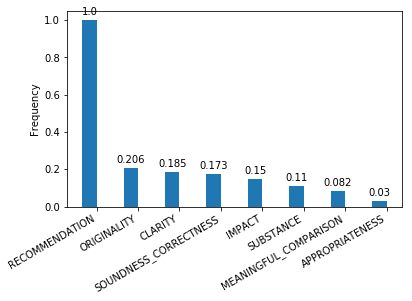

In [133]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


fig, ax = plt.subplots()

x = np.arange(len(x_axis))  # the label locations
width = 0.35  # the width of the bars

rects1 = ax.bar(x - width/2, y_axis, width)
# rects2 = ax.bar(x + width/2, rejected_freq, width, label='Rejected papers')

ax.set_ylabel('Frequency')
ax.set_xticks(x)
ax.set_xticklabels(x_axis)
# ax.legend()
fig.autofmt_xdate()

autolabel(rects1)
# autolabel(rects2)

plt.savefig("images/asp_score_freq.png")
plt.show()

### Box plot

In [185]:
acl_aspects_ticks = ["SOUNDNESS_CORRECTNESS", "CLARITY", "ORIGINALITY", "SUBSTANCE", "MEANINGFUL_COMPARISON", "APPROPRIATENESS", "IMPACT", "RECOMMENDATION"]

data_acc = [[],]*len(acl_aspects_ticks)
data_rej = [[],]*len(acl_aspects_ticks)

for k in aspect_dict:
    if aspect_dict[k]["dec"]:
#         print(aspect_dict[k])
        for idx in range(0, len(acl_aspects_ticks)):
            if acl_aspects_ticks[idx] in aspect_dict[k]:
#                 print(acl_aspects_ticks[idx])
                data_acc[idx] = data_acc[idx] + aspect_dict[k][acl_aspects_ticks[idx]]
#         print(data_acc)
#         break
    else:
        for idx in range(0, len(acl_aspects_ticks)):
            if acl_aspects_ticks[idx] in aspect_dict[k]:
                data_rej[idx] = data_rej[idx] + aspect_dict[k][acl_aspects_ticks[idx]]

In [183]:
data_acc = [[],]*len(acl_aspects_ticks)
data_acc[0] = data_acc[0] + [7, 7, 4]
data_acc

[[7, 7, 4], [], [], [], [], [], [], []]

In [186]:
len(acl_aspects_ticks)

8

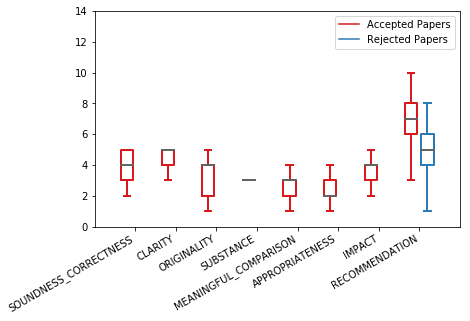

In [219]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color, linewidth=2)
    plt.setp(bp['whiskers'], color=color, linewidth=2)
    plt.setp(bp['caps'], color=color, linewidth=2)
    plt.setp(bp['medians'], color="#636363", linewidth=2)

fig = plt.figure()
# ax.grid()
boxprops = dict(linewidth=2)
                
bpl = plt.boxplot(data_acc, positions=np.array(range(len(data_acc)))*2.0-0.4, sym='', widths=0.6, boxprops=boxprops)
bpr = plt.boxplot(data_rej, positions=np.array(range(len(data_rej)))*2.0+0.4, sym='', widths=0.6, boxprops=boxprops)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Accepted Papers')
plt.plot([], c='#2C7BB6', label='Rejected Papers')
plt.legend()

plt.xticks(range(0, len(acl_aspects_ticks) * 2, 2), acl_aspects_ticks)
# plt.xticks(acl_aspects_ticks)
plt.xlim(-2, len(acl_aspects_ticks)*2)
plt.ylim(0, 14)
plt.tight_layout()
fig.autofmt_xdate()

plt.savefig("images/aspscores_boxplot.png")

In [215]:
data_list = [data_acc, data_rej]
data_counters = [{}, {}]
c = 0

for i in data_list:
    for j in range(0, len(i)):
        data_counters[c][acl_aspects_ticks[j]] = (len(i[j]), round(np.mean(i[j]), 2), round(np.std(i[j]), 2))
    c += 1

In [216]:
print(data_counters[0].items(), end="\n")
print(data_counters[1].items(), end="\n")

dict_items([('SOUNDNESS_CORRECTNESS', (109, 3.94, 1.03)), ('CLARITY', (118, 4.29, 0.97)), ('RECOMMENDATION', (505, 6.94, 1.02)), ('ORIGINALITY', (141, 3.35, 1.11)), ('SUBSTANCE', (70, 3.03, 0.91)), ('MEANINGFUL_COMPARISON', (43, 2.77, 1.16)), ('APPROPRIATENESS', (15, 2.67, 1.19)), ('IMPACT', (83, 3.48, 1.09))])
dict_items([('SOUNDNESS_CORRECTNESS', (0, nan, nan)), ('CLARITY', (0, nan, nan)), ('RECOMMENDATION', (764, 4.82, 1.25)), ('ORIGINALITY', (0, nan, nan)), ('SUBSTANCE', (0, nan, nan)), ('MEANINGFUL_COMPARISON', (0, nan, nan)), ('APPROPRIATENESS', (0, nan, nan)), ('IMPACT', (0, nan, nan))])
